# 1. Introduction

Name: Matthew Ingram

Original Date: November 3, 2025

Most Recent Update: November 13, 2025

My project for this semester is to create an image classification model which can be given an input of an image of a food item (of various types), and then attempt to classify that food item.

This project uses a modified version of the "Food Image Classification Dataset" available on Kaggle at the following link:
https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset

The modifications of the dataset relate to making all of the food folders/directories have uniform naming conventions, stripping out underscores and converting all names to lowercase.

This project is based on the "Digit_Recognition.ipynb" lab.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # Convert to one-hot-encoding.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, Input
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from os import listdir
from sklearn.preprocessing import LabelEncoder

sns.set(style='white', context='notebook', palette='deep')

# 2. Data Preparation

In [2]:
# Unzip the zipped dataset.
import zipfile
with zipfile.ZipFile("/content/Food Dataset.zip", "r") as zipref:
  zipref.extractall("/content")

apple pie = 400 images, 1.0 weight
baked potato = 400 images, 1.0 weight
burger = 331 images, 1.2085 weight
butter naan = 307 images, 1.3029 weight
chai = 344 images, 1.1628 weight
chapati = 327 images, 1.2232 weight
cheesecake = 400 images, 1.0 weight
chicken curry = 400 images, 1.0 weight
chole bhature = 376 images, 1.0638 weight
crispy chicken = 400 images, 1.0 weight
dal makhani = 295 images, 1.3559 weight
dhokla = 245 images, 1.6327 weight
donut = 400 images, 1.0 weight
fried rice = 350 images, 1.1429 weight
fries = 400 images, 1.0 weight
hot dog = 400 images, 1.0 weight
ice cream = 400 images, 1.0 weight
idli = 302 images, 1.3245 weight
jalebi = 288 images, 1.3889 weight
kaathi rolls = 279 images, 1.4337 weight
kadai paneer = 334 images, 1.1976 weight
kulfi = 214 images, 1.8692 weight
masala dosa = 273 images, 1.4652 weight
momos = 323 images, 1.2384 weight
omelette = 400 images, 1.0 weight
paani puri = 144 images, 2.7778 weight
pakode = 269 images, 1.487 weight
pav bhaji = 305 i

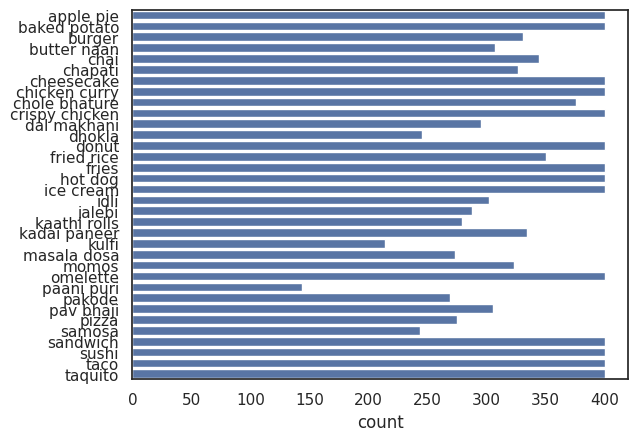

In [3]:
# Load the data.
X_train = []
Y_train = []

# Class weights to help training focus on getting the best accuracy on all classes, not just classes with a lot
# of training images.
class_weights = {}

food_types = ["apple pie", "baked potato", "burger", "butter naan", "chai",
              "chapati", "cheesecake", "chicken curry", "chole bhature", "crispy chicken",
              "dal makhani", "dhokla", "donut", "fried rice", "fries",
              "hot dog", "ice cream", "idli", "jalebi", "kaathi rolls",
              "kadai paneer", "kulfi", "masala dosa", "momos", "omelette",
              "paani puri", "pakode", "pav bhaji", "pizza", "samosa",
              "sandwich", "sushi", "taco", "taquito"]

# Sets a uniform size for all images, and sets a maximum amount of any class of image to prevent overrepresentation.
image_size = 128
food_count_allowed = 400

food_index = 0
for food_type in food_types:
  current_food_count = 0
  print(food_type, end = " = ")

  for food_image in listdir("/content/Food Dataset/" + food_type):
    if current_food_count >= food_count_allowed:
      break
    current_food_count = current_food_count + 1
    Y_train.append(food_type)

    image_instance = cv2.imread("/content/Food Dataset/" + food_type + "/" + food_image)
    image_instance = cv2.cvtColor(image_instance, cv2.COLOR_BGR2RGB)
    image_instance = cv2.resize(image_instance, (image_size, image_size))

    X_train.append(image_instance)

  class_weights[food_index] = float(food_count_allowed) / float(current_food_count)
  print(current_food_count, "images,", round(class_weights[food_index], 4), end = " weight\n")
  food_index = food_index + 1

print(len(X_train), end = " images total\n")
class_count = len(food_types)

# Stack up lists into ndarrays.
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

# Visualize the relative sizes of data for classes.
g = sns.countplot(Y_train)

# Normalize the data for faster convergence.
X_train = X_train / 255.0

In [4]:
# Fit the Y training data to integer values based on alphabetical sorting, then convert those integers to one hot vectors for training.
# "burger" -> 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# "sushi" -> 31 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(Y_train)
Y_train = to_categorical(Y_train, num_classes = class_count)

In [5]:
# Set the seed for randomization.
random_seed = 2

# Split the training and the validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train,
                                                  test_size = 0.1,
                                                  random_state = random_seed)

100


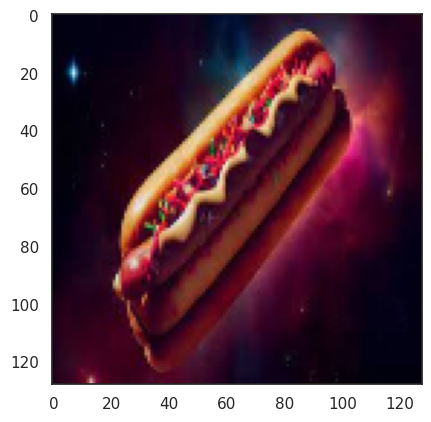

In [41]:
# For checking various images.
image_to_show_index = input()
g = plt.imshow(X_train[int(image_to_show_index)][:,:,:])

# 3. CNN (Convolutional Neural Network)

In [6]:
# Sets up the CNN model.
# The CNN layering that I went with is:
# [Conv2D(relu)]*2 -> MaxPool2D -> [Conv2D(relu)]*2 -> Dropout ->
# -> MaxPool2D -> [Conv2D(relu)]*2 -> AveragePooling2D -> Flatten -> Dense -> Dropout -> Output

model = Sequential()

model.add(Input((image_size, image_size, 3)))

model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'same',
                 activation ='relu'))
model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation ='relu'))
model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation ='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters = 256,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation ='relu'))
model.add(Conv2D(filters = 256,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation ='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(class_count, activation = "softmax"))

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0003, rho = 0.9, epsilon = 1e-08, weight_decay = 0.0),
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [7]:
# Set a learning rate annealer, this one reduces learning rate as val_accuracy fails to improve.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 5,
                                            verbose = 1,
                                            factor = 1.0/3.0,
                                            min_lr = 1e-07)

# Sets up epochs and batch_size for training.
epochs = 80
batch_size = class_count

# Adds data augmentation to discourage the overfitting of data.
datagen = ImageDataGenerator(rotation_range = 10,  # Randomly rotates images in the range.
                             zoom_range = 0.15, # Randomly zooms image.
                             channel_shift_range = 0.025, # Randomly modifies color channels within range.
                             width_shift_range = 0.15,  # Randomly shifts images horizontally (fraction of total width).
                             height_shift_range = 0.15,  # Randomly shifts images vertically (fraction of total height).
                             horizontal_flip = True,  # Randomly flips images horizontally.
                             vertical_flip = False)  # Randomly flips images vertically.

datagen.fit(X_train)

In [8]:
# Fit the model.
history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val),
                              class_weight = class_weights,
                              verbose = 2, steps_per_epoch = (X_train.shape[0] // batch_size),
                              callbacks = [learning_rate_reduction])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
302/302 - 106s - 351ms/step - accuracy: 0.0540 - loss: 4.1059 - val_accuracy: 0.0875 - val_loss: 3.2890 - learning_rate: 3.0000e-04
Epoch 2/80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


302/302 - 1s - 4ms/step - accuracy: 0.0294 - loss: 3.7205 - val_accuracy: 0.1015 - val_loss: 3.2672 - learning_rate: 3.0000e-04
Epoch 3/80
302/302 - 59s - 195ms/step - accuracy: 0.0965 - loss: 3.8856 - val_accuracy: 0.1347 - val_loss: 3.1857 - learning_rate: 3.0000e-04
Epoch 4/80
302/302 - 1s - 5ms/step - accuracy: 0.1471 - loss: 3.8816 - val_accuracy: 0.1190 - val_loss: 3.1603 - learning_rate: 3.0000e-04
Epoch 5/80
302/302 - 60s - 199ms/step - accuracy: 0.1310 - loss: 3.7090 - val_accuracy: 0.1776 - val_loss: 2.9039 - learning_rate: 3.0000e-04
Epoch 6/80
302/302 - 1s - 5ms/step - accuracy: 0.2059 - loss: 3.7590 - val_accuracy: 0.1776 - val_loss: 2.9258 - learning_rate: 3.0000e-04
Epoch 7/80
302/302 - 58s - 193ms/step - accuracy: 0.1685 - loss: 3.5347 - val_accuracy: 0.2327 - val_loss: 2.7905 - learning_rate: 3.0000e-04
Epoch 8/80
302/302 - 1s - 5ms/step - accuracy: 0.2647 - loss: 2.9303 - val_accuracy: 0.1942 - val_loss: 2.8390 - learning_rate: 3.0000e-04
Epoch 9/80
302/302 - 59s - 19

In [13]:
model.save("/content/food_classification_model.keras")

# 4. Evaluate the model

In [ ]:
model = tf.keras.models.load_model("/content/food_classification_model.keras")

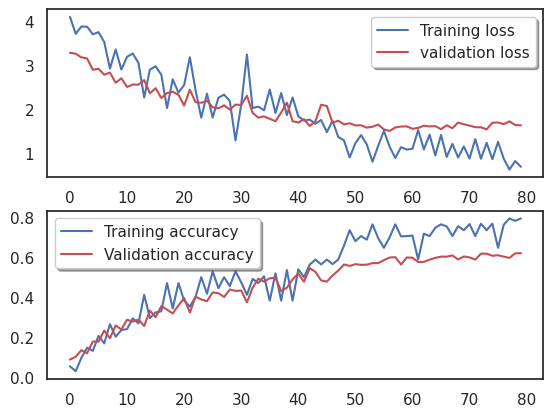

In [9]:
# Plot the loss and accuracy curves for training and validation.

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


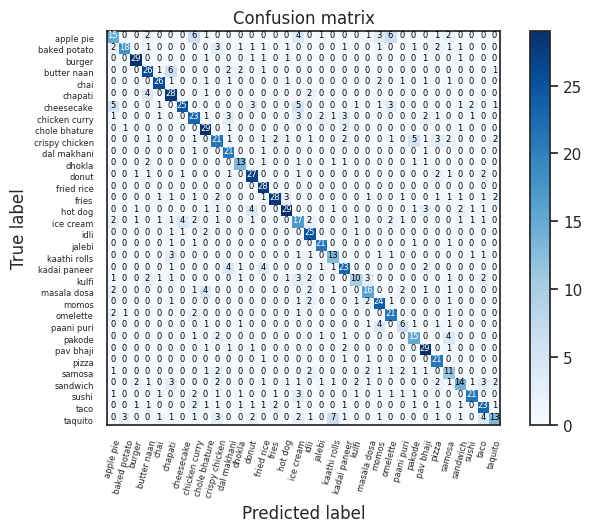

In [10]:
# Confusion matrix, for showing what predicted labels correspond to the actual labels in training data.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize = 6)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.xticks(classes, food_types, rotation = 75, fontsize = 6)
    plt.yticks(classes, food_types, fontsize = 6)

# Predict the values from the validation dataset.
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors.
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations to one hot vectors.
Y_true = np.argmax(Y_val, axis = 1)

# Compute the confusion matrix.
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix.
plot_confusion_matrix(confusion_mtx, classes = range(class_count))

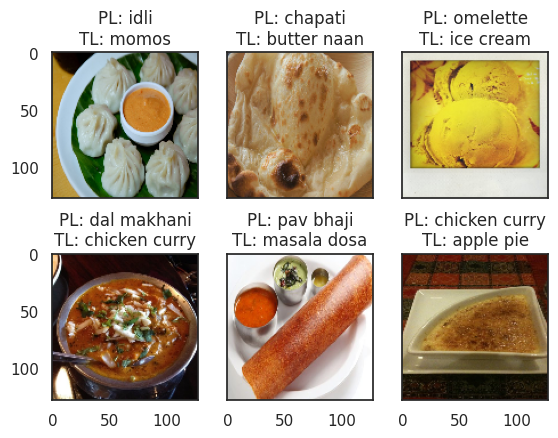

In [11]:
# Display some error results.
# Errors are difference between predicted labels and true labels.
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,
                   img_errors,
                   pred_errors,
                   obs_errors):
    # This function shows 6 images with their predicted and real labels.
    # PL = Predicted label
    # TL = True label
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((image_size, image_size, 3)))
            ax[row,col].set_title("PL: {}\nTL: {}".format(food_types[pred_errors[error]], food_types[obs_errors[error]]))
            n += 1

# Probabilities of the wrong predicted numbers.
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set.
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis = 1))

# Difference between the probability of the predicted label and the true label.
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors.
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors.
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors.
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Please enter the path to the file you wish to classify (.jpg): /content/pizza.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The model predicts that the image is of: pizza
Confidence of prediction: 0.9999578


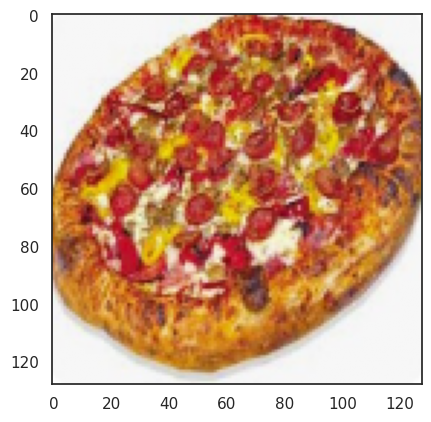

In [39]:
# Interactive cell for testing new input images, enter the file path to the .jpg
# image you want to test, then the model will evaluate the image and give a prediction.
image_to_classify = input("Please enter the path to the file you wish to classify (.jpg): ")

classify_image = cv2.imread(image_to_classify)
classify_image = cv2.cvtColor(classify_image, cv2.COLOR_BGR2RGB)
classify_image = cv2.resize(classify_image, (image_size, image_size))

image_container = []
image_container.append(classify_image)
image_container = np.stack(image_container)

image_container = image_container / 255.0

result = model.predict(image_container)
print("The model predicts that the image is of:", food_types[np.argmax(result[0])])
print("Confidence of prediction:", max(result[0]))

g = plt.imshow(image_container[0][:,:,:])